In [1]:
import pandas as pd
import xarray as xr
import datetime as dt
import numpy as np
import dask.array as da

import dask
from dask.distributed import Client
from dask import delayed
from sea_breeze import load_model_data, sea_breeze_funcs

#dask optimiser
#https://coecms.github.io/posts/2023-09-20-dask-optimiser.html?highlight=dask+optimiser
#/g/data/gb02/sg7549/aus2200_sbi_test.ipynb

In [2]:
client = Client()
client

2024-12-09 21:14:22,596 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-12-09 21:14:22,599 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-12-09 21:14:22,604 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37557 instead
  warnings.warn(


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0005.gadi.nci.org.au/62696/proxy/37557/status,
Dashboard: /node/gadi-cpu-bdw-0005.gadi.nci.org.au/62696/proxy/37557/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40257,Workers: 7
Dashboard: /node/gadi-cpu-bdw-0005.gadi.nci.org.au/62696/proxy/37557/status,Total threads: 7
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43505,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0005.gadi.nci.org.au/62696/proxy/38447/status,Memory: 0 B
Nanny: tcp://127.0.0.1:39307,


### First set up bounds of data to load in for AUS2200

In [3]:
#Define lat lon slices (in this case, essentially the whole AUS2200 domain
#Whole domain
lon_slice = slice(108,158.5)
lat_slice = slice(-45.7,-6.9)  
#D1
# lon_slice = slice(108,133.49)
# lat_slice = slice(-45.7,-26.25)  
#Perth
# lat_slice=slice(-38,-30)
# lon_slice=slice(112,120)

#Define times to slice
t1="2016-01-01 01:00"
t2="2016-01-31 23:00"

#Because boundary layer height data (zmla) is offset by 30 minutes compared with U and V wind data,
# define a separate time slice for later centering
# dt_hours=1
# t1_zmla = pd.to_datetime(t1) + dt.timedelta(hours=-dt_hours)
# t2_zmla = pd.to_datetime(t2) + dt.timedelta(hours=dt_hours)

# #We will need to destagger the U and V winds, so we need to load in an extra grid point in lat
# # and lon for v and u, respectively. Set up these slices now
# dx = 0.02   #Grid spacing in degrees lat-lon
# u_lon_slice=slice(lon_slice.start-dx*0.5,lon_slice.stop+dx*0.5)
# v_lat_slice=slice(lat_slice.start-dx*0.5,lat_slice.stop+dx*0.5)  

In [9]:
lev_chunk = {}
time_chunk = 1
lat_chunk = -1
lon_chunk = -1
chunks = {"lev":lev_chunk,"time":time_chunk,"lat":lat_chunk,"lon":lon_chunk}
orog, lsm = load_model_data.load_aus2200_static(
    "mjo-elnino",
    lon_slice,
    lat_slice)
aus2200_ua = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "ua",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="lon",
        hgt_slice=slice(0,5000)),
          "1hr")

aus2200_va = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "va",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="lat",
        hgt_slice=slice(0,5000)),
          "1hr")
aus2200_zmla = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "zmla",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="time"),
          "1hr")

In [5]:
angle_ds = load_model_data.get_coastline_angle_kernel(
    lsm,
    compute=False,
    lat_slice=lat_slice,
    lon_slice=lon_slice,
    path_to_load="/g/data/gb02/ab4502/coastline_data/aus2200_v3.nc")

In [10]:
aus2200_va

<xarray.DataArray 'va' (time: 743, lev: 38, lat: 1960, lon: 2550)> Size: 564GB
dask.array<truediv, shape=(743, 38, 1960, 2550), dtype=float32, chunksize=(1, 14, 1960, 2550), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 304B 2.5 13.33 33.33 ... 4.433e+03 4.68e+03 4.933e+03
  * lon      (lon) float64 20kB 108.0 108.0 108.1 108.1 ... 158.4 158.5 158.5
  * lat      (lat) float64 16kB -45.7 -45.68 -45.66 ... -6.951 -6.931 -6.911
  * time     (time) datetime64[ns] 6kB 2016-01-01T01:00:00 ... 2016-01-31T23:...

In [11]:
aus2200_wind = xr.Dataset({"u":aus2200_ua,"v":aus2200_va})
sbi = sea_breeze_funcs.calc_sbi(aus2200_wind,
                            angle_ds,
                            subtract_mean=False,
                            height_method="blh",
                            blh_da=aus2200_zmla,
                            vert_coord="lev")

In [12]:
sbi

<xarray.Dataset> Size: 30GB
Dimensions:  (lat: 1960, lon: 2550, time: 743)
Coordinates:
  * lat      (lat) float64 16kB -45.7 -45.68 -45.66 ... -6.951 -6.931 -6.911
  * lon      (lon) float64 20kB 108.0 108.0 108.1 108.1 ... 158.4 158.5 158.5
  * time     (time) datetime64[ns] 6kB 2016-01-01T01:00:00 ... 2016-01-31T23:...
Data variables:
    sbi      (time, lat, lon) float64 30GB dask.array<chunksize=(1, 1960, 2550), meta=np.ndarray>

In [ ]:
sbi.to_netcdf("/scratch/gb02/ab4502/sbi_test.nc",engine="netcdf4")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 304.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-12-09 15:26:11,094 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:42839
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/iostream.py", line 1124, in write_to_fd
    return self.socket.send(data)  # type: ignore
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/dat

In [12]:
#sbi.sbi.sel(time="2016-01-29 08:00").plot()

In [13]:
#sbi.sbi.sel(time="2016-01-29 08:00").to_netcdf("/scratch/gb02/ab4502/sbi_test.nc",engine="netcdf4")

### When I now try with subtracting the daily mean (subtract_mean=True), things don't end well
So it appears the problem is with subtracting a rolling time mean. 

As desribed here: https://github.com/dask/dask/issues/874

In [14]:
#Call function again, but this time subtract the daily mean u and v wind components.
#Before calling the function, rechunk to one time chunk for efficiency

angle_ds = xr.open_dataset("/g/data/gb02/ab4502/coastline_data/aus2200_v3.nc").sel(lat=lat_slice,lon=lon_slice)

sbi = calc_sbi(aus2200_wind,
        angle_ds,
        subtract_mean=True,
        height_mean=False,
        blh_da=aus2200_zmla,
        alpha_height=0,
        height_method="blh",
        blh_rolling=0,
        vert_coord="lev")

In [15]:
sbi

<xarray.Dataset> Size: 8GB
Dimensions:  (time: 743, lat: 983, lon: 1287)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2016-01-01T01:00:00 ... 2016-01-31T23:...
  * lat      (lat) float64 8kB -45.7 -45.68 -45.66 ... -26.3 -26.28 -26.26
  * lon      (lon) float64 10kB 108.0 108.0 108.1 108.1 ... 133.4 133.5 133.5
Data variables:
    sbi      (time, lat, lon) int64 8GB dask.array<chunksize=(1, 268, 494), meta=np.ndarray>

In [16]:
#sbi.sbi.sel(time="2016-01-29 08:00").plot()

In [ ]:
sbi.to_netcdf("/scratch/gb02/ab4502/sbi_test.nc",engine="netcdf4")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 70.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
#Mem taken for 31 days, 1/4 domain > 1000 GB
#31 days, 1/4 domain, auto lat/lon chunks > 350 GB

### But even just computing the rolling time mean and saving to disk for later (to avoid dask scheduler issues) also takes a very long time

In [7]:
time_window = 24
min_periods = 12
u_mean = aus2200_ua.\
            rolling(dim={"time":time_window},center=True,min_periods=min_periods).\
            mean().persist()
# u_mean = aus2200_ua.resample({"time":"1D"},
#                     offset=dt.timedelta(hours=18),
#                     origin="start_day",
#                     label="left",
#                     closed="left",
#                     restore_coord_dims=True).mean().persist()

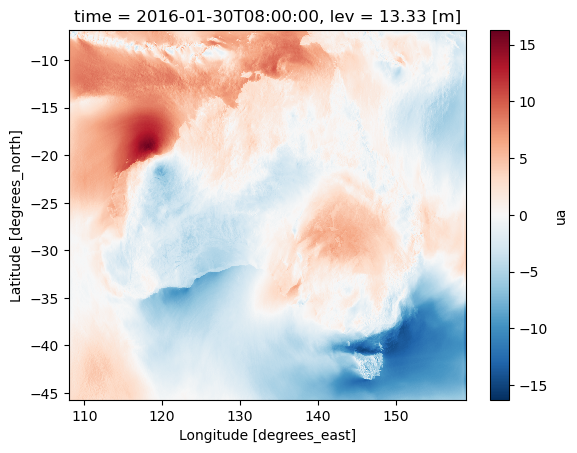

In [8]:
u_mean.sel(time="2016-01-30 08:00").isel(lev=1).plot()

In [18]:
u_mean

<xarray.DataArray 'ua' (time: 49, lev: 38, lat: 1963, lon: 2574)> Size: 38GB
dask.array<truediv, shape=(49, 38, 1963, 2574), dtype=float32, chunksize=(24, 14, 1963, 519), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 392B 2016-01-30 ... 2016-02-01
  * lev      (lev) float64 304B 2.5 13.33 33.33 ... 4.433e+03 4.68e+03 4.933e+03
  * lat      (lat) float64 16kB -45.7 -45.68 -45.66 ... -6.891 -6.871 -6.852
  * lon      (lon) float64 21kB 108.0 108.0 108.1 108.1 ... 158.9 158.9 159.0

In [ ]:
groups = u_mean.groupby(u_mean.time.dt.date)
cnt=0
for n,g in groups:
    print(n)
    g.to_netcdf("/scratch/gb02/ab4502/tmp/u_mean_"+str(cnt)+".nc")
    cnt=cnt+1

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


2016-01-30


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


2016-01-31
